# Adding external variables to our model

So far, each forecast model has used only the time series itself to make predictions. However, external values can be have an impact on time series and be good predictors of future values.

## The SARIMAX model

$$
y_t = \text{SARIMAX}(p,d,q)(P,D,Q)_m + \sum_{i=1}^n \beta_i X^i_t
$$

where $X^i_t$ is the $i$-th of $n$ external variables and $\beta$ are tunable parameters.

In [1]:
import statsmodels.api as sm

macro_econ_data = sm.datasets.macrodata.load_pandas().data

macro_econ_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


If we set e.g. `realgpt` as our endogenous variable, then the remaining variables are all exogenous.

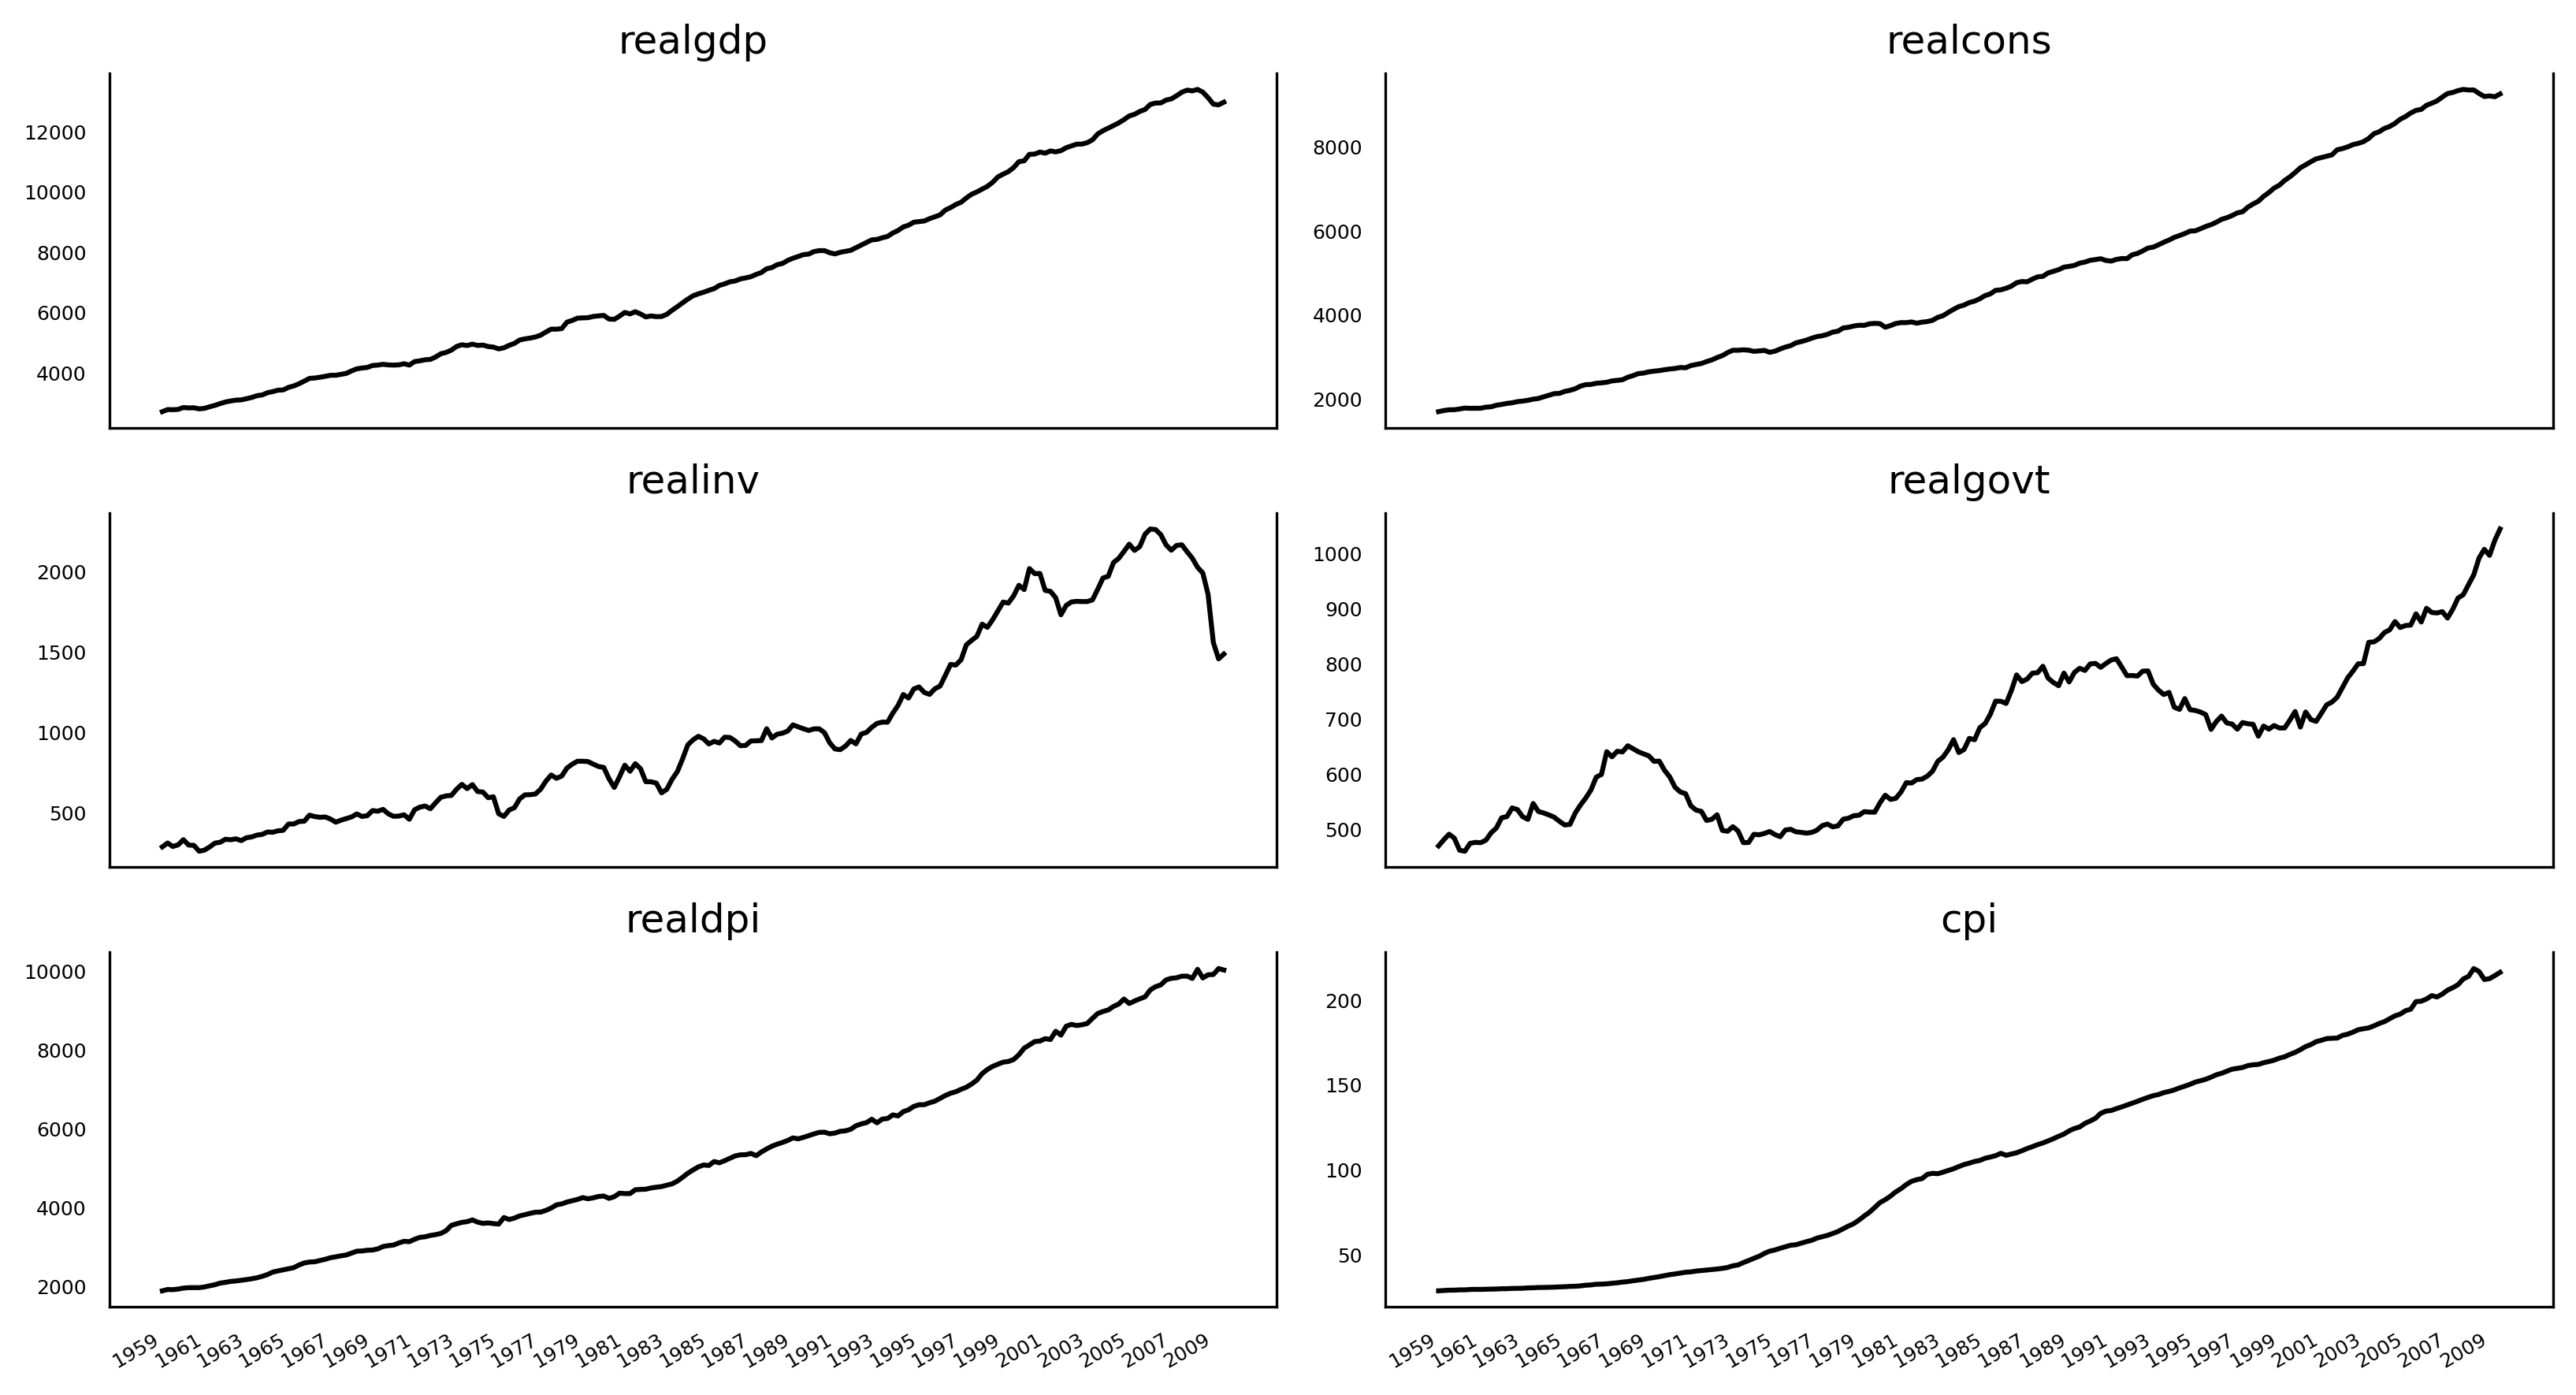

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

fig, axs = plt.subplots(3, 2, dpi=300, figsize=(11,6))
axs: np.ndarray[Axes]

for i, ax in enumerate(axs.flatten()):
    ax: Axes
    col = macro_econ_data.columns[i+2]
    data = macro_econ_data[col]
    ax.plot(data, 'k-')
    ax.set_title(col)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axs, xticks=np.arange(0, len(macro_econ_data), 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
fig.tight_layout()

The p-value associated with each coefficient of each predictor of the SARIMAX model should not be used for feature selection. The p-value tests whether a coefficient is significantly different from 0 or not. IF the p-value is less than 0.05, we reject the null hypothesis and conclude that the coefficient is significantly different from 0. It does not determine whether a predictor is useful for forecasting. So, do not disregard predictors just because of their p-values. Selecting the model by minimizing the AIC does this.

Including exogenous variables can be helpful but issues can arise when forecasting multiple timesteps into the future. Recall that a SARIMAX model uses $\text{SARIMA}(p,d,q)(P,D,Q)_m$ model an a linear combination of exogenous variables to predict one timestep into the future. But what if we want to predict two timesteps into the future? The SARIMAX model requires us to forecast exogenous variables too. A solution is to forecast the exogenous variables using a version of the SARIMA model, but that model will have some error associated with it. Therefore, having to forecast an exogenous variable to forecast our predictions can quickly degrade as we predict more timesteps into the future.

In [3]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

In [4]:
import pandas as pd
from typing import Union
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data: Union[pd.Series, np.ndarray]):
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')

In [5]:
test_stationarity(target)

ADF Statistic: 1.750
p-value: 0.998


In [6]:
test_stationarity(target.diff().dropna())
# d = 1
# D = 0 
# since we do not need to take seasonality into account to make series stationary

ADF Statistic: -6.306
p-value: 0.000


In [7]:
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter('ignore', ConvergenceWarning)

pqPQ = tuple[int, int, int, int]

def optimize_SARIMAX(
    endog: pd.Series, 
    exog: pd.DataFrame,
    order_list: list[pqPQ],
    d: int,
    D: int,
    s: int,
) -> pd.DataFrame:
    results: list[tuple(pqPQ, np.float64)] = []
    for order in tqdm(order_list):
        p, q, P, Q = order
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                simple_differencing=False
            ).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append((order, aic))
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, q, P, Q)', 'AIC']
    result_df = (result_df
                 .sort_values(by='AIC', ascending=True)
                 .reset_index(drop=True))
    return result_df

In [8]:
from itertools import product

p = range(0, 4)
d = 1
q = range(0, 4)
P = range(0, 4)
D = 0
Q = range(0, 4)
s = 4

params = list(product(p, q, P, Q))

target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, params,
                             d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using z

,"(p, q, P, Q)",AIC
0,"(3, 3, 0, 0)",1742.862504
1,"(3, 3, 1, 0)",1744.966765
2,"(3, 3, 0, 1)",1744.997035
3,"(2, 2, 0, 0)",1745.489011
4,"(2, 2, 0, 1)",1745.952305
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

best_model = SARIMAX(target_train, exog_train,
                     order=(3, d, 3), seasonal_order=(0, D, 0, s),
                     simple_differencing=False)
best_model_fit: SARIMAXResults = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.431
Date:                Mon, 16 Oct 2023   AIC                           1742.863
Time:                        12:27:01   BIC                           1782.382
Sample:                             0   HQIC                          1758.857
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9668      0.044     21.767      0.000       0.880       1.054
realinv        1.0147      0.033     31.046      0.000       0.951       1.079
realgovt       0.7237      0.127      5.711      0.0

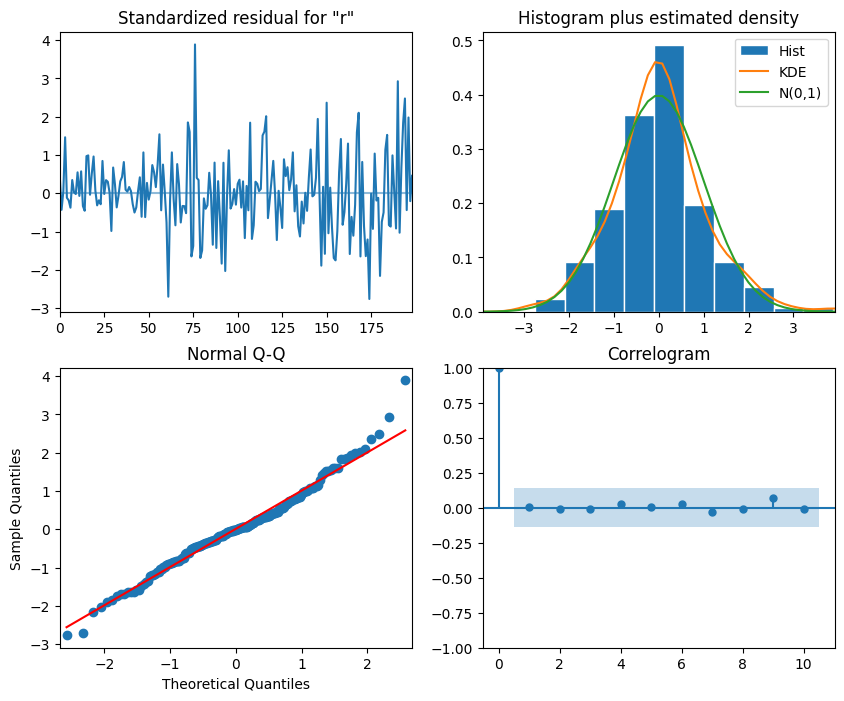

In [10]:
best_model_fit.plot_diagnostics(figsize=(10,8));

In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def get_sarimax_resid_pvalues(model_results: SARIMAXResults):
    residuals = model_results.resid
    lb_df = acorr_ljungbox(residuals, np.arange(1, 11))
    lb_df = lb_df.sort_values(by='lb_pvalue', ascending=True)
    return lb_df

get_sarimax_resid_pvalues(best_model_fit)

,lb_stat,lb_pvalue
1,0.095274,0.757576
4,1.169404,0.883110
2,0.207802,0.901315
5,1.171126,0.947617
3,0.211279,0.975748
6,1.190592,0.977347
7,1.386310,0.985987
8,1.396696,0.994293
9,1.750302,0.994829
10,1.755707,0.997893


In [13]:
from typing import Literal
from statsmodels.tsa.statespace.mlemodel import PredictionResults

def rolling_forecast(
    endog: pd.Series,
    exog: pd.DataFrame,
    train_len: int,
    horizon: int,
    window: int,
    method: Literal['last', 'SARIMAX']
) -> np.ndarray:
    total_len = train_len + horizon
    assert len(endog) == total_len
    pred = np.empty(horizon)
    if method == 'last':
        for i in range(0, horizon, window):
            last = endog[:train_len+i].iloc[-1]
            pred[i:i+window] = last
        return pred
    elif method == 'SARIMAX':
        for i in range(0, horizon, window):
            model = SARIMAX(endog[:train_len+i],
                            exog[:train_len+i],
                            order=(3, d, 3),
                            seasonal_order=(0, D, 0, s),
                            simple_differencing=False)
            res: SARIMAXResults = model.fit(disp=False)
            predictions: PredictionResults = res.get_prediction(exog=exog)
            predictions_mean: pd.Series = predictions.predicted_mean
            oos_pred = predictions_mean.iloc[-window:]
            pred[i:i+window] = oos_pred.values
        return pred
    else:
        raise RuntimeError('Unknown method')

In [22]:
target_train = target[:196]
target_test = target[196:]
pred_df = pd.DataFrame({'actual': target_test})
TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1
pred_last = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')
pred_df['last'] = pd.Series()
pred_df['SARIMAX'] = pd.Series()
pred_df['last'].loc[196:] = pred_last
pred_df['SARIMAX'].loc[196:] = pred_SARIMAX

C:\Users\Ben\AppData\Local\Temp\ipykernel_36020\3647718383.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['last'].loc[196:] = pred_last
C:\Users\Ben\AppData\Local\Temp\ipykernel_36020\3647718383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['SARIMAX'].loc[196:] = pred_SARIMAX


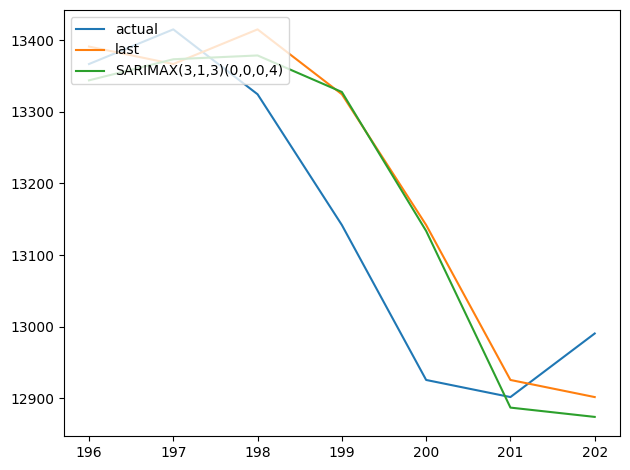

In [26]:
fig, ax = plt.subplots()
ax: Axes

ax.plot(pred_df['actual'], label='actual')
ax.plot(pred_df['last'], label='last')
ax.plot(pred_df['SARIMAX'], label='SARIMAX(3,1,3)(0,0,0,4)')
ax.legend(loc=2)

fig.tight_layout()

In [27]:
from sklearn.metrics import mean_absolute_percentage_error

mape_last = mean_absolute_percentage_error(pred_df['actual'], pred_df['last'])
mape_SARIMAX = mean_absolute_percentage_error(pred_df['actual'], pred_df['SARIMAX'])

print(f'MAPE of naive seasonal: {100*mape_last:.2f}%')
print(f'MAPE of SARIMAX: {100*mape_SARIMAX:.2f}%')

MAPE of naive seasonal: 0.74%
MAPE of ARIMA: 0.70%
